In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def data_ret():
    pwd = os.getcwd()+'\\health_data.csv'
    dataset = pd.read_csv(pwd)    
    dataset = dataset.sample(frac = 1)
    X = dataset.iloc[:,:-1].values
    y = dataset.iloc[:,-1:].values
    datasize = X.shape[0]
    X_train = X[:(datasize*7)//10,:]
    y_train = y[:(datasize*7)//10,:]
    X_test = X[(datasize*7)//10:,:]
    y_test = y[(datasize*7)//10:,:]

    X_train_mean = np.sum(X_train,axis=0).reshape(1,-1)/X_train.shape[0]
    X_train_var = np.sqrt(np.sum(np.square(X_train-X_train_mean),axis=0).reshape(1,-1)) / X_train.shape[0]
    X_train = (X_train-X_train_mean) / X_train_var
    X_train = np.append(np.ones((X_train.shape[0],1)),X_train,axis=1)
    X_test = (X_test-X_train_mean) / X_train_var
    X_test = np.append(np.ones((X_test.shape[0],1)),X_test,axis=1)
    return X_train,y_train,X_test,y_test

In [4]:
def gradDesc(X,y,theta,hypothesis,loss_function,regularizer,alpha,lambda1,lambda2):
    h,loss,gradient = loss_function(X,theta,y,hypothesis)
    if(regularizer==elastic_net_reg):
        reg_loss,reg_grad = regularizer(lambda1,lambda2,theta)
    else:
        reg_loss,reg_grad = regularizer(lambda1,theta)
    # loss += reg_loss
    gradient += reg_grad

    return(loss,gradient)

In [5]:
def mse_loss(X,theta,y,hypothesis):
    siz = y.shape[0]
    h = hypothesis(X,theta)
    diff = h-y
    mse = ( np.sum(np.square(diff),axis=0))[0]
    gradient = np.dot(np.transpose(X),diff) / siz
    return(h,mse,gradient)

def mae_loss(X,theta,y,hypothesis):
    siz = y.shape[0]
    num_feat = y.shape[1]
    h = hypothesis(X,theta)
    diff = h-y
    diff_sign = np.ones((siz,1))
    diff_sign[diff[:,0]<0] = -1
    mae = np.sum(np.abs(h),axis=0)[0] / siz
    gradient = np.sum(diff_sign*X,axis=0).reshape(-1,1)
    return(h,mae,gradient)

def ce_loss(X,theta,y,hypothesis):
    siz = y.shape[0]
    h = hypothesis(X,theta)
    h_comp = 1-h
    diff = h - y
    ce = np.sum(-y*np.log(h)-(1-y)*np.log(1-h),axis=0) [0]
    gradient = np.dot(np.transpose(X),diff).reshape(-1,1) / siz
    return(h,ce,gradient)   

In [6]:
def lin_hyp(X,theta):
    # print(np.dot(X,theta).shape)
    return (np.dot(X,theta))
def log_hyp(X,theta):
    a = lin_hyp(X,theta)
    return ( 1/(1+np.exp(-a)) )
def null_regularizer(alpha,theta):
    a = np.zeros(theta.shape)
    return(0,a)
def l1_reg(alpha,theta):
    reg_loss = alpha*theta
    reg_grad = alpha
    return(reg_loss,reg_grad)
def l2_reg(alpha,theta):
    reg_loss = alpha * np.square(theta)
    reg_grad = 2 * alpha * theta
    return(reg_loss,reg_grad)
def elastic_net_reg(lambda1,lambda2,theta):
    a1,a2 = l1_reg(lambda1,theta)
    b1,b2 = l2_reg(lambda2,theta)
    return( a1+b1 , a2+b2 )

In [15]:
def linReg(X,y,iter=1000,alpha=0.01,batchSize=32,hypothesis = lin_hyp,loss_function=mse_loss,regularizer=l2_reg,lambda1 = 0.01,lambd2_elasnet = 0.01):
    theta = np.random.random((X.shape[1],1))
    # print(theta)
    # print(theta)
    datasize = X.shape[0]
    loss_list = []
    loss_epoch,_ = gradDesc(X,y,theta,hypothesis,loss_function,regularizer,alpha,lambda1, lambd2_elasnet)
    for i in range(iter):
        if((i+1)%10==0):
            loss_list.append(loss_epoch)
            print('Loss for {} iterations: {}'.format(i+1,loss_epoch))
        fro = 0
        loss_epoch = 0
        while(True):
            to = min(fro+batchSize,datasize)
            l,theta_grad = gradDesc(X[fro:to,:],y[fro:to,:],theta,hypothesis,loss_function,regularizer,alpha,lambda1, lambd2_elasnet)
            # print(theta_grad)
            loss_epoch += l
            
            # print(theta_grad)
            theta -= (alpha*theta_grad)
            ll,_ = gradDesc(X,y,theta,hypothesis,loss_function,regularizer,alpha,lambda1, lambd2_elasnet)
            loss_list.append(ll)
            fro = to

            if(to>=datasize):
                break
        
    
    return (theta,loss_epoch,loss_list)


In [17]:
def acc(y_test,X_test,opt_theta,pr=False,thresh=0.5):
    y_pred = log_hyp(X_test,opt_theta)

    loss_y = y_pred - y_test

    test_size = y_pred.shape[0]
    total_loss_y = np.dot(np.ones((1,test_size)),np.square(loss_y))[0,0] / test_size

    y_pred_thresh = y_pred>=thresh

    tp = np.sum((y_pred_thresh+y_test)==2 , axis=0)[0]
    tn = np.sum(y_pred_thresh==y_test , axis=0)[0] - tp
    fp = np.sum(y_pred_thresh , axis=0)[0]-tp
    fn = test_size-tp-tn-fp

    print('tp: {} , tn: {} , fp: {} , fn: {}'.format(tp,tn,fp,fn))

    acc = (tp+tn)/test_size
    prec = (tp)/(tp+fp)
    recl = (tp)/(tp+fn)
    f1 = 2*prec*recl/(prec+recl)
    if pr:
        print('Accuracy: {}'.format( acc  ))
        print('Precision: {}'.format( prec  ))
        print('Recall: {}'.format( recl  ))
        print('F1 score: {}'.format( f1  ))
    return(tp,fp,tn,fn)

In [18]:
tp,fp,tn,fn = 0,0,0,0
x = []
y = []
for i in range(1):
    X_train,y_train,X_test,y_test = data_ret()
    train_datasize = X_train.shape[0]
    opt_theta, train_loss , loss_list = linReg(X_train,y_train,iter=2000,alpha=0.001,batchSize=10,hypothesis = log_hyp,loss_function=mse_loss,regularizer=l2_reg,lambda1=0.01,lambd2_elasnet = 0.001)
    for i in np.arange(0,1.1,0.1):
        a,b,c,d = acc(y_test,X_test,opt_theta,thresh=i)
        y.append(a/(a+d))
        x.append(b/(b+c))
        tp+=a
        fp+=b
        tn+=c
        fn+=d
# acc = (tp+tn)/(tp+tn+fp+fn)
# prec = (tp)/(tp+fp)
# recl = (tp)/(tp+fn)
# f1 = 2*prec*recl/(prec+recl)
# print('...........FINAL..........')
# print('tp: {} , tn: {} , fp: {} , fn: {}'.format(tp,tn,fp,fn))
# print('Accuracy: {}'.format( acc  ))
# print('Precision: {}'.format( prec  ))
# print('Recall: {}'.format( recl  ))
# print('F1 score: {}'.format( f1  ))
print(x,y)


Loss for 10 iterations: 65.58044589619264
Loss for 20 iterations: 55.53963152461505
Loss for 30 iterations: 54.34445048725765
Loss for 40 iterations: 53.78630483891943
Loss for 50 iterations: 53.263799547955884
Loss for 60 iterations: 52.76917457240358
Loss for 70 iterations: 52.301901167557
Loss for 80 iterations: 51.86153331938035
Loss for 90 iterations: 51.44748842364184
Loss for 100 iterations: 51.059056983468274
Loss for 110 iterations: 50.69542103180034
Loss for 120 iterations: 50.35567309389417
Loss for 130 iterations: 50.03883489424326
Loss for 140 iterations: 49.74387533114914
Loss for 150 iterations: 49.469727338334614
Loss for 160 iterations: 49.2153033466025
Loss for 170 iterations: 48.97950915039766
Loss for 180 iterations: 48.761256069346395
Loss for 190 iterations: 48.55947136982027
Loss for 200 iterations: 48.373106974161324
Loss for 210 iterations: 48.20114653457566
Loss for 220 iterations: 48.04261098508455
Loss for 230 iterations: 47.896562709319
Loss for 240 iterati

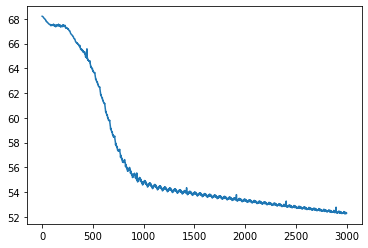

In [22]:
# print(loss_list)
x = np.arange(len(loss_list[:3000]))
plt.plot(x,loss_list[:3000])

In [ ]:
plt.plot(x, y)

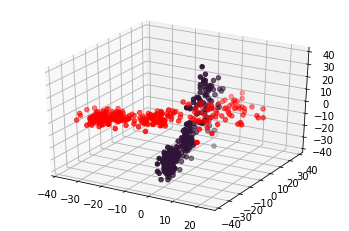

In [25]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection="3d")


z_points = X_train[y_train[:,0]==0][:,0]
x_points = X_train[y_train[:,0]==0][:,1]
y_points = X_train[y_train[:,0]==0][:,2]
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');
z_points = X_train[y_train[:,0]==0][:,0]
x_points = X_train[y_train[:,0]==0][:,1]
y_points = X_train[y_train[:,0]==0][:,2]
ax.scatter3D(z_points,x_points,y_points, c=z_points, cmap='twilight_shifted');

plt.show()

In [13]:
# import matplotlib.pyplot as plt
# import numpy as np

# x = np.array([1,2,3,4,5])
# y = np.array([2,1,3,6,7])

# cluster = np.array([1,1,1,2,2]) 

# fig, ax = plt.subplots()

# ax.scatter(x[cluster==1],y[cluster==1], marker='^')
# ax.scatter(x[cluster==2],y[cluster==2], marker='s')

# plt.show()